# **Introducción**

Para este proyecto, se decidió utilizar el dataset de Brain Tumor. Cómo se sabe, las personas con mejor tasa de recuperación de un cáncer cerebral son aquellas que pudieron ser diagnosticadas de manera temprana. Es por esto por lo que el enfoque de este proyecto es en la diagnosticación temprana de tumores cerebrales.

El área de la medicina es relevante en el área de la computación y de los modelos predictivos ya que ofrece la capacidad de entrenar modelos con características claras. Es decir; las CNN son capaces de aprender automáticamente características relevantes de las imágenes, sin necesidad de una extracción manual de características. También,  las CNN pueden aprender jerarquías de características, desde características simples a complejas, lo que es beneficioso para la detección de tumores.

# ***Datos***

In [2]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files

# Sube el archivo kaggle.json que descargaste
uploaded = files.upload()

# Mueve el archivo a la ubicación adecuada
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


Saving kaggle.json to kaggle.json


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:00<00:00, 204MB/s]
100% 149M/149M [00:00<00:00, 198MB/s]


In [6]:
!unzip brain-tumor-mri-dataset.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: 

In [3]:
train_data_path = '/content/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [4]:
train_df

,filepaths,label
0,/content/Training/meningioma/Tr-me_0414.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0098.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0968.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0498.jpg,meningioma
4,/content/Training/meningioma/Tr-me_1044.jpg,meningioma
...,...,...
5707,/content/Training/glioma/Tr-gl_1288.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0651.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0857.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0816.jpg,glioma


In [5]:
test_data_path = '/content/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
test_df

,filepaths,label
0,/content/Testing/meningioma/Te-me_0183.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0050.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0269.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0011.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0132.jpg,meningioma
...,...,...
1306,/content/Testing/glioma/Te-gl_0215.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0209.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0048.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0198.jpg,glioma


In [7]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [23]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# **Desarrollo de Modelo**

In [13]:
model = Sequential()

# Primer bloque convolucional
model.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segundo bloque convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercer bloque convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarto bloque convolucional
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para conectar a capas densas
model.add(Flatten())

# Capa densa con 256 neuronas y activación relu
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar el sobreajuste

# Capa de salida con activación softmax para la clasificación
model.add(Dense(len(train_df['label'].unique()), activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestra un resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 28, 128)       0

In [14]:
epochs = 5  # Ajusta el número de épocas según sea necesario

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // batch_size
)


Epoch 1/5
357/357 [==============================] - 963s 3s/step - loss: 2.7128 - accuracy: 0.7346 - val_loss: 0.5665 - val_accuracy: 0.7766
Epoch 2/5
357/357 [==============================] - 941s 3s/step - loss: 0.3819 - accuracy: 0.8659 - val_loss: 0.4207 - val_accuracy: 0.8297
Epoch 3/5
357/357 [==============================] - 969s 3s/step - loss: 0.2899 - accuracy: 0.8890 - val_loss: 0.4069 - val_accuracy: 0.8469
Epoch 4/5
357/357 [==============================] - 935s 3s/step - loss: 0.2585 - accuracy: 0.9095 - val_loss: 0.3933 - val_accuracy: 0.8516
Epoch 5/5
357/357 [==============================] - 957s 3s/step - loss: 0.2245 - accuracy: 0.9182 - val_loss: 0.2483 - val_accuracy: 0.9047


In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


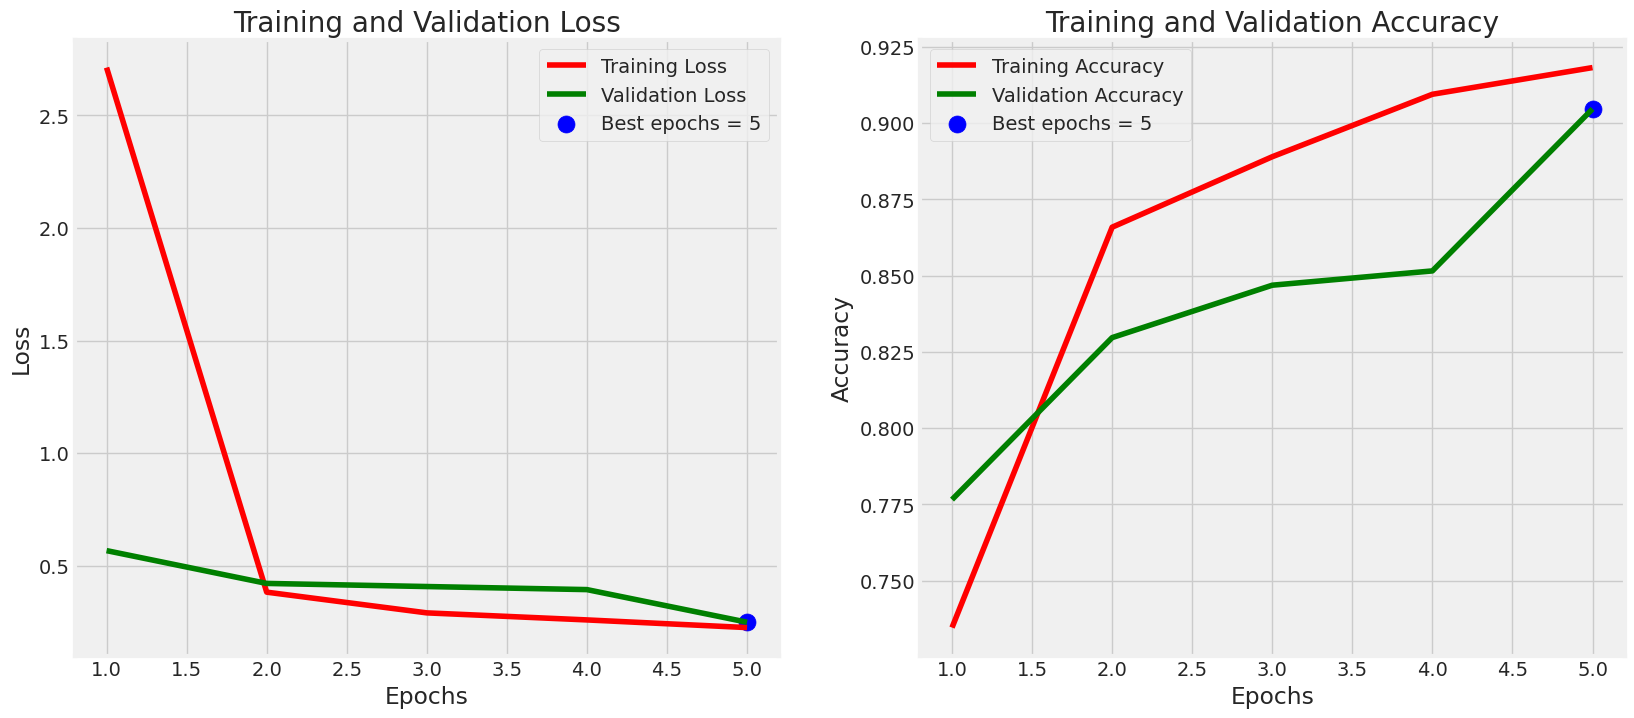

In [16]:

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# **Ajuste del Modelo**

Ya que el modelo tarda demasiado tiempo en correr, pienso que puede llegar a ser ineficiente y poco óptimo. Para esto, se decidió disminuir las capas de la red.

También, se decidió cambiar y hacer un ajuste de otros hiperparámetros como el método de activación y la generación de Imagenes. En este segundo modelo, vamos vamos a cambiar la manera en la que generamos las imágenes. A pesar de que los resultados del primer modelo eran bastante buenos, queremos implementar algo que se tarde mucho menos.

In [26]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(rescale=1./255)



In [29]:
model2 = Sequential()

# Primer bloque convolucional
model2.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Segundo bloque convolucional
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Tercer bloque convolucional
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarto bloque convolucional
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten para conectar a capas densas
model2.add(Flatten())

# Capa densa con 256 neuronas y activación relu
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))  # Dropout para evitar el sobreajuste

# Capa de salida con activación softmax para la clasificación
model2.add(Dense(len(train_df['label'].unique()), activation='softmax'))

# Compilar el modelo
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestra un resumen del modelo
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 121, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 59, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 28, 128)      

In [30]:
epochs = 5  # Ajusta el número de épocas según sea necesario

history = model2.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // batch_size
)

Epoch 1/5
357/357 [==============================] - 974s 3s/step - loss: 2.6009 - accuracy: 0.7332 - val_loss: 0.5918 - val_accuracy: 0.7812
Epoch 2/5
357/357 [==============================] - 942s 3s/step - loss: 0.4193 - accuracy: 0.8515 - val_loss: 0.4760 - val_accuracy: 0.8109
Epoch 3/5
357/357 [==============================] - 890s 2s/step - loss: 0.3259 - accuracy: 0.8808 - val_loss: 0.4012 - val_accuracy: 0.8297
Epoch 4/5
357/357 [==============================] - 888s 2s/step - loss: 0.2940 - accuracy: 0.9007 - val_loss: 0.2824 - val_accuracy: 0.8906
Epoch 5/5
357/357 [==============================] - 885s 2s/step - loss: 0.2390 - accuracy: 0.9146 - val_loss: 0.2246 - val_accuracy: 0.9125


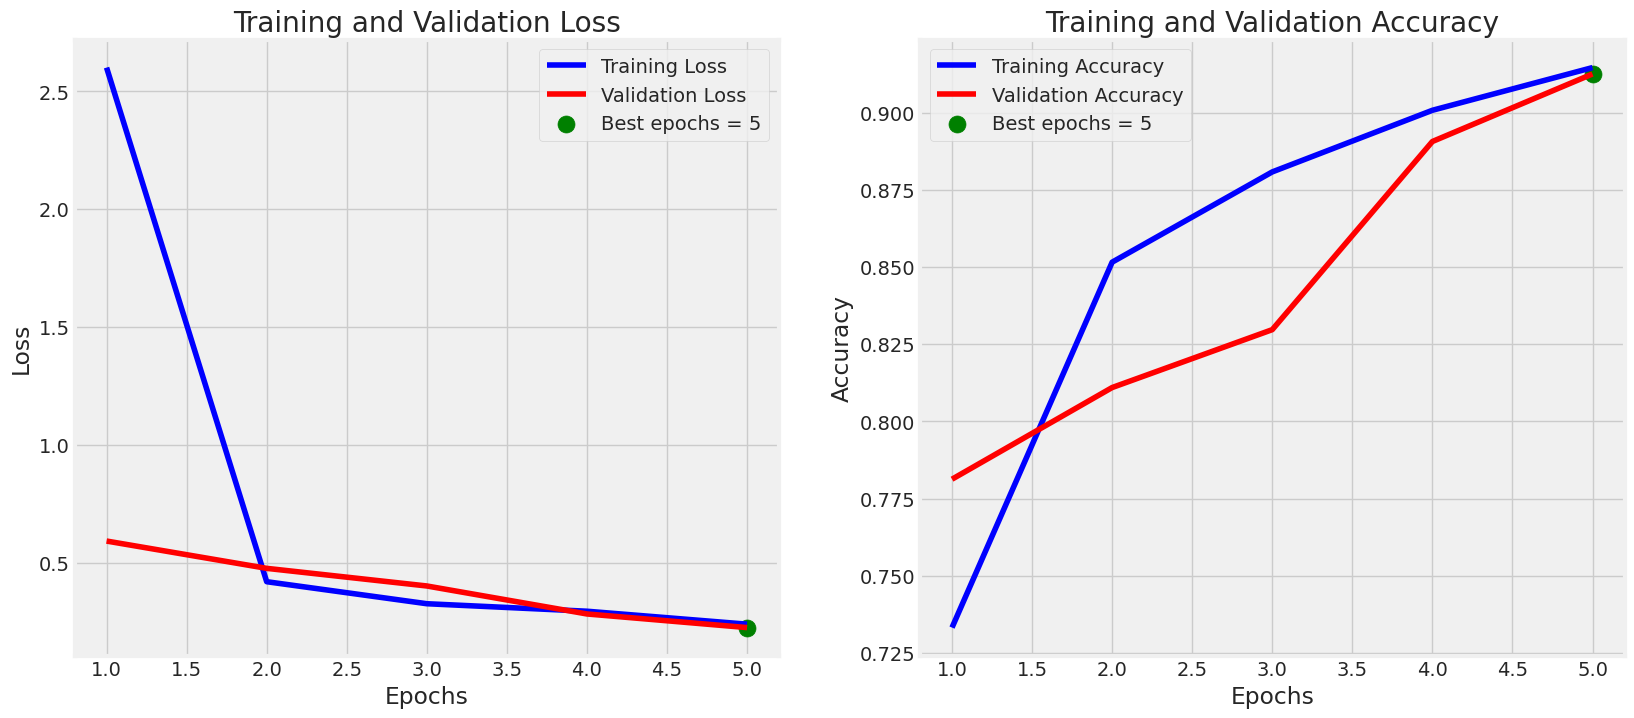

In [31]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'b' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'b' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'green',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

Finalmente, después de ver estos resultados, se decidió que lo mejor sería jugar con las capas y los hiperparámetros, respetando cómo se generaron las imágenes en el primer modelo. Esto se debe a que el modelo se tardó demasiado en correr, por lo que se perdió mucho tiempo trabajando en él.



In [32]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [34]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(len(train_df['label'].unique()), activation='softmax'))
# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestra un resumen del modelo
model3.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 121, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 54, 59, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 203904)            0         
                                                                 
 dense_22 (Dense)            (None, 128)             

In [35]:
epochs = 5  # Ajusta el número de épocas según sea necesario

history = model3.fit(
    train_gen,
    steps_per_epoch=train_gen.n // batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // batch_size
)

Epoch 1/5
357/357 [==============================] - 645s 2s/step - loss: 19.2085 - accuracy: 0.7703 - val_loss: 0.5699 - val_accuracy: 0.7891
Epoch 2/5
357/357 [==============================] - 641s 2s/step - loss: 0.3881 - accuracy: 0.8794 - val_loss: 0.4413 - val_accuracy: 0.8687
Epoch 3/5
357/357 [==============================] - 642s 2s/step - loss: 0.2891 - accuracy: 0.9116 - val_loss: 0.3542 - val_accuracy: 0.9141
Epoch 4/5
357/357 [==============================] - 642s 2s/step - loss: 0.2227 - accuracy: 0.9329 - val_loss: 0.3060 - val_accuracy: 0.9094
Epoch 5/5
357/357 [==============================] - 643s 2s/step - loss: 0.2086 - accuracy: 0.9424 - val_loss: 0.2484 - val_accuracy: 0.9234


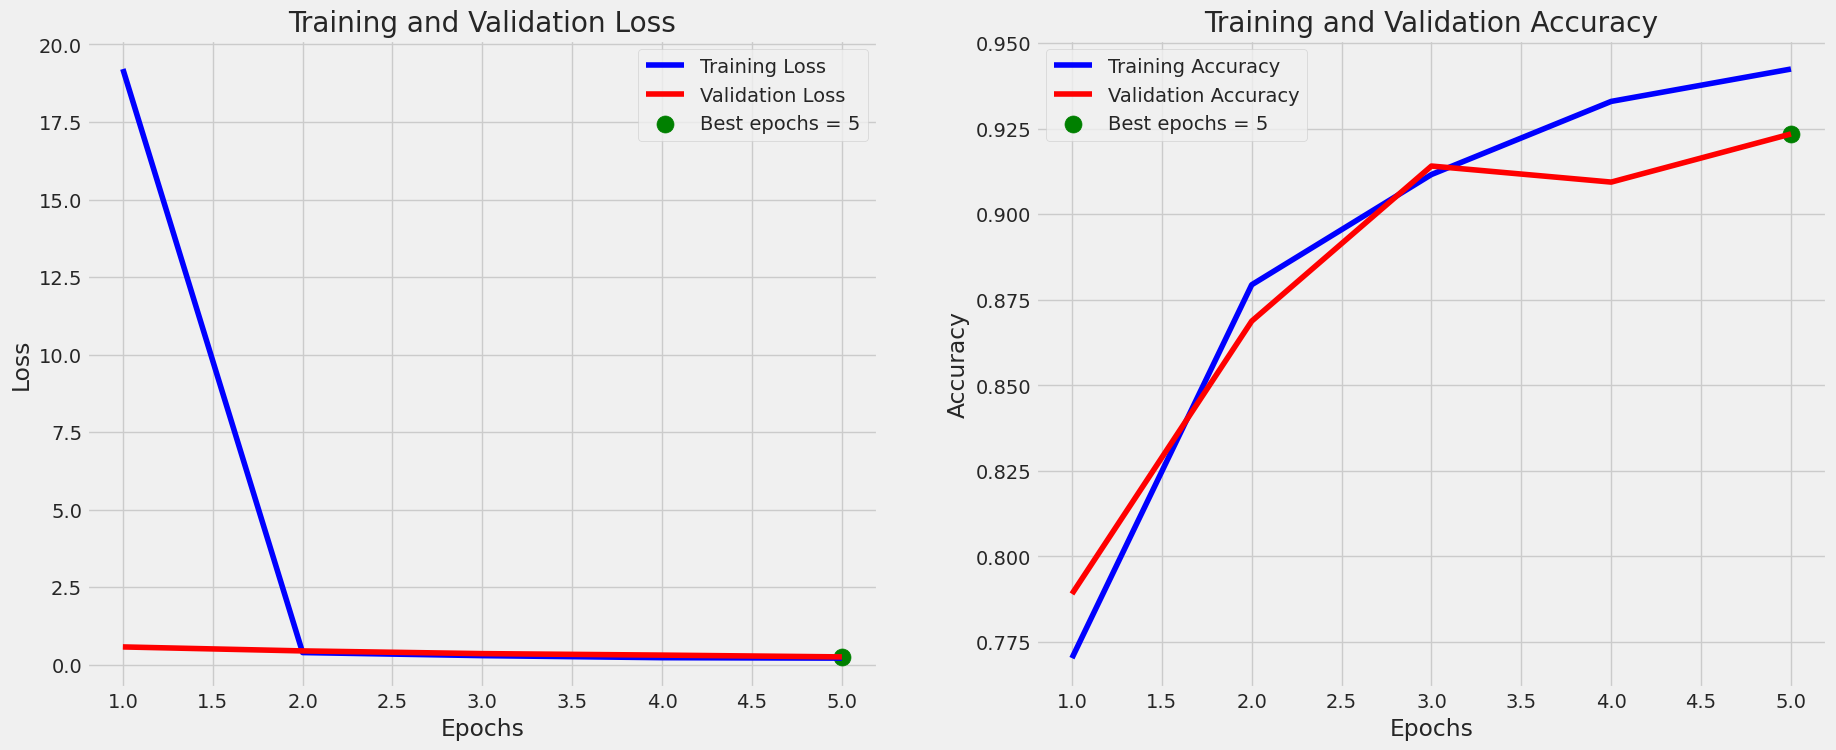

In [36]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'


plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'b' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'r' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'green',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'b' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'r' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'green',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# **Resultados**

In [37]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")


41/41 [==============================] - 31s 752ms/step - loss: 7.6164 - accuracy: 0.3582
Loss: 7.62
Accuracy: 0.36


In [38]:
# Evaluate the model on the test set
evaluation = model2.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")

41/41 [==============================] - 32s 789ms/step - loss: 0.2450 - accuracy: 0.9009
Loss: 0.24
Accuracy: 0.90


In [39]:
# Evaluate the model on the test set
evaluation = model3.evaluate(test_gen, steps=test_gen.n // batch_size)
print(f"Loss: {evaluation[0]:.2f}")
print(f"Accuracy: {evaluation[1]:.2f}")

41/41 [==============================] - 19s 466ms/step - loss: 0.2524 - accuracy: 0.9131
Loss: 0.25
Accuracy: 0.91


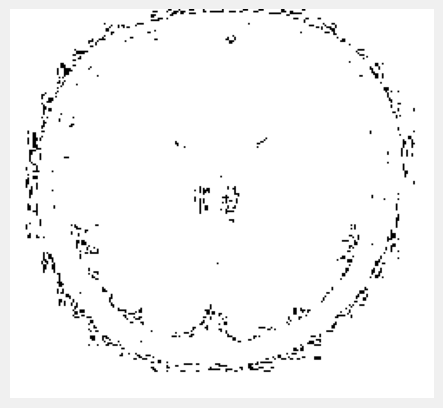

True Label: 1
1/1 [==============================] - 1s 714ms/step
Model Prediction:  meningioma


In [43]:
# Choose a random test image
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Display the test image
plt.axis('off')
plt.imshow(test_image[0], cmap='gray')  # Assuming it's a grayscale image
plt.show()

# Convert one-hot encoded label to scalar
true_label = np.argmax(test_label, axis=-1)
print(f"True Label: {test_gen.classes[true_label[0]]}")

# Get the model predictions
pred = model.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model Prediction: ", predicted_label)



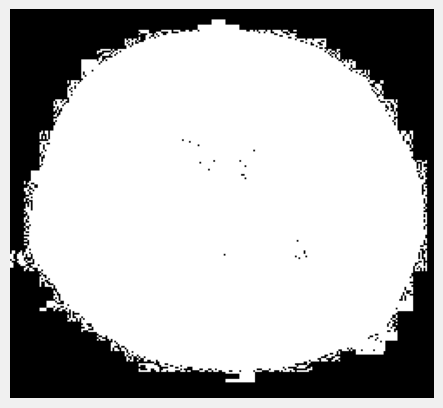

True Label: 1
1/1 [==============================] - 1s 770ms/step
Model Prediction:  meningioma


In [47]:
# Choose a random test image
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Display the test image
plt.axis('off')
plt.imshow(test_image[0], cmap='gray')  # Assuming it's a grayscale image
plt.show()

# Convert one-hot encoded label to scalar
true_label = np.argmax(test_label, axis=-1)
print(f"True Label: {test_gen.classes[true_label[0]]}")

# Get the model predictions
pred = model2.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model Prediction: ", predicted_label)


Exception ignored in: <function _xla_gc_callback at 0x7e6c275aecb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


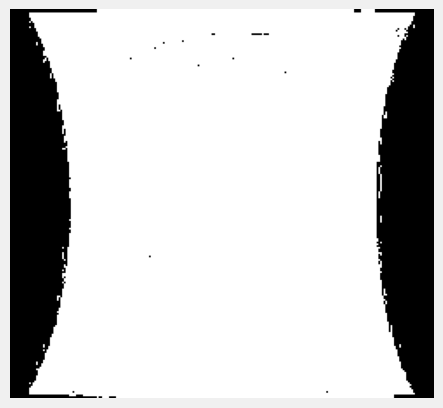

True Label: 0
1/1 [==============================] - 1s 729ms/step
Model Prediction:  meningioma


In [48]:
# Choose a random test image
random_inx = np.random.choice(len(test_gen))
test_image, test_label = test_gen[random_inx]

# Display the test image
plt.axis('off')
plt.imshow(test_image[0], cmap='gray')  # Assuming it's a grayscale image
plt.show()

# Convert one-hot encoded label to scalar
true_label = np.argmax(test_label, axis=-1)
print(f"True Label: {test_gen.classes[true_label[0]]}")

# Get the model predictions
pred = model3.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model Prediction: ", predicted_label)


In [44]:
# Get the model predictions
pred = model.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model: ", predicted_label)

1/1 [==============================] - 1s 612ms/step
Model:  meningioma


In [49]:
# Get the model predictions
pred = model2.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model: ", predicted_label)

1/1 [==============================] - 1s 764ms/step
Model:  meningioma


In [51]:
# Get the model predictions
pred = model3.predict(test_image)
predicted_label = labels[np.argmax(pred)]

print("Model: ", predicted_label)

1/1 [==============================] - 1s 913ms/step
Model:  meningioma


In [52]:
# Check model's predictions for each possible class
df = pd.DataFrame(pred, columns=train_df['label'].unique())
df



,meningioma,notumor,pituitary,glioma
0,9.999997e-01,8.304007e-09,3.021889e-08,2.649242e-07
1,9.927023e-01,6.976321e-03,3.020862e-05,2.911438e-04
2,1.394011e-12,9.999999e-01,1.942900e-13,2.290291e-21
3,5.337833e-15,3.868538e-11,9.999999e-01,9.839772e-18
4,7.067167e-03,9.766997e-01,1.253651e-02,3.696546e-03
5,3.363370e-16,1.308310e-10,9.999999e-01,3.468310e-15
6,3.650725e-01,3.998072e-02,1.695865e-03,5.932509e-01
7,6.002133e-21,1.470123e-21,9.999999e-01,6.347413e-26
8,5.177717e-08,1.375030e-05,2.408056e-07,9.999859e-01
9,9.999999e-01,4.113524e-11,1.488500e-10,1.137053e-09


<Axes: >

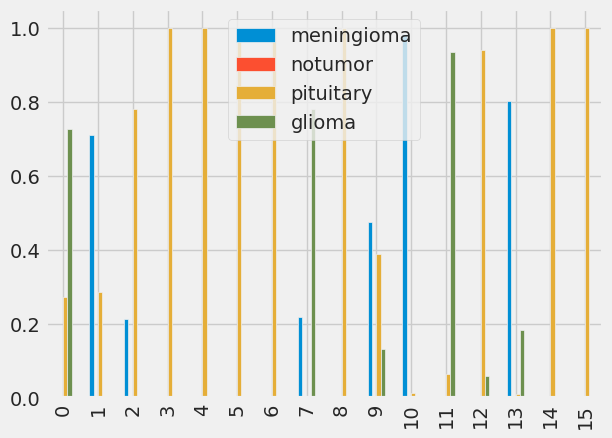

In [50]:
# Visualize model's predictions
df.plot.bar()

# **Conclusiones**

Después de todos estos modelos creados, podemos llegar a la conclusión de que el mejor modelo que obtuvimos fue el tercer modelo, el que tenía menores capas.

Esto puede deberse a la optimización y tal vez exista un poco de overfitting en el primer modelo, a pesar de tener lo que parece ser un buen desempeño. Esto lo pudimos comprobar cuando vimos su desempeño en las contra las predicciones en las imagenes de Test.

Me parece que es importante recalcar que en primer instancia, podría parecer que el primer modelo y el último tienen resultados similares, sin embargo, debido a las capas, pudimos ver un mejor desempeño en este último.

Pienso que un área de oportunidad favorable podría ser jugar con el generador de imágenes, ya que mientras que dio el peor modelo, puede ser que exista algún parametro que podamos modificar que nos dé un mejor desempeño.

También sería bueno compararlo con un RNN, para comparar de manera experimental sus desempeños en el mismo data set.